In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt2
import time
import datetime
import os
import matplotlib.style
from pandas.core.common import flatten
from functools import partial, reduce
from scipy.signal import argrelextrema


In [2]:
plt.style.use('ggplot')

In [3]:
path = 'C:\\Users\Serene\\Finance\\Strategies\\igdata'

In [4]:
pairs_list = []
for filename in os.listdir(path):
    if filename.endswith('.csv'):
        pairs_list.append(filename.split('.')[0])
print(pairs_list)


['naturalgas_15Min', 'naturalgas_1H', 'naturalgas_4H', 'naturalgas_5Min', 'naturalgas_D']


In [5]:

df = {}
dd = {}

for pair in range(len(pairs_list)):
    t = str(pairs_list[pair].split('_')[1])
    df[pair] = pd.read_csv(path + '\\' + pairs_list[pair]+'.csv', header = 2)
    #df[pair].drop([4,5,6,7,8,9,10,11,12], axis=01)
    #df[pair] = df[pair].iloc[0,1,2,3,4,13]
    df[pair] = df[pair].iloc[:,[0,1,2,3,4,5,6,7,8,9,10,11,12,13]]
    df[pair].columns = ['Date', 'Bid Open', 'Bid High', 'Bid Low', 'Bid Close',\
                                'Ask Open', 'Ask High', 'Ask Low', 'Ask Close',\
                                'Open', 'High', 'Low', 'Close', 'Volume']
    df[pair]['Open'] = df[pair]['Bid Open']
    df[pair]['High'] = df[pair]['Bid High']
    df[pair]['Low'] = df[pair]['Bid Low']
    df[pair]['Close'] = df[pair]['Bid Close']
    #df[pair]['Date'] = df[pair]['Date'].str.split(' ').str[0:2]
    #df[pair]['Date'] = df[pair]['Date'].str.join(' ')
    df[pair].set_index('Date', inplace = True)
    df[pair].index = pd.to_datetime(df[pair].index, format = '%Y.%m.%d %H:%M:%S.%f')
    df[pair]['Day'] = df[pair].index.dayofweek
    dmap = {0: 'Mon', 1: 'Tue', 2: 'Wed', 3: 'Thu', 4: 'Fri', 5: 'Sat', 6: 'Sun'}
    df[pair]['Day'] = df[pair]['Day'].map(dmap)
    df[pair]['min'] = ''
    df[pair]['max'] = ''
    dd[t] = df[pair]
    
for key in dd:
    print(f'Key: {key} - rows: {len(dd[key])}')


Key: 15Min - rows: 9503
Key: 1H - rows: 5913
Key: 4H - rows: 1598
Key: 5Min - rows: 8461
Key: D - rows: 939


In [6]:
def SMA(df, period):
    df[str(period) + '_sma'] = df['Close'].rolling(period).mean()
    return df[str(period) + '_sma']

def EMA(df, period):
    df[str(period) + '_ema'] = df['Close'].ewm(span = period,adjust=False).mean()
    return  df[str(period) + '_ema']

def PriceCrossover(df, price_col, indicator_col):
    conditions  = [ (df[indicator_col].shift(1) > df[price_col].shift(1)) & (df[indicator_col] < df[price_col]),\
                    (df[indicator_col].shift(1) < df[price_col].shift(1)) & (df[indicator_col] > df[price_col])]
    choices     = ['BreakUp','BreakDown']
    df[price_col +'_'+ indicator_col + '_crossover'] = np.select(conditions, choices, default=np.nan)
    df[price_col +'_'+ indicator_col + '_crossover_price'] = np.where(df[price_col +'_'+ indicator_col + '_crossover']==\
                                                                      'nan','nan',df[price_col])
    return  df

def Trend(df):
    conditions  = [(df['200_sma']> df['400_sma']),\
                    (df['200_sma'] < df['400_sma'])]
    choices     = ['Up','Down']
    df['Trend'] = np.select(conditions, choices, default=np.nan)
    return  df['Trend']

def ATR(df, n):
    df = df.copy()
    df['High-Low'] = abs(df['High'] - df['Low'])
    df['High-PrevClose'] = abs(df['High'] - df['Close'].shift(1))
    df['Low-PrevClose'] = abs(df['Low'] - df['Close'].shift(1))
    df['TR'] = df[['High-Low', 'High-PrevClose', 'Low-PrevClose']].max(axis = 1, skipna = False)
    df['ATR'] = df['TR'].rolling(n).mean()
    df = df.drop(['High-Low', 'High-PrevClose', 'Low-PrevClose'], axis = 1)
    return df

def CAGR(df, source_df):
    df = df.copy()
    n = len(source_df) / (252*24)
    return round((((df['cum_res'][-1] / account_size)**(1/n)) - 1) * 100, 1)

def sharpe_ratio(df):
    df = df.copy()
    returns = df['cum_res'].pct_change()
    volatility = returns.std() * np.sqrt(252)
    return round((returns.mean() - 0.02) / volatility, 2)

def max_drawdown(df):
    df = df.copy()
    cum_returns = (1 + df['cum_res']).cumprod()
    drawdown = 1 - df['cum_res'].div(df['cum_res'].cummax())
    return round(max(drawdown.expanding().max() * 100), 2)


In [7]:
#Strategy parameters
account_size = 10000
slippage = 2
size = 1
ATR_SL = 0.5
spread = 2
plot_trades = False
pair = 'D'

In [8]:
for res in dd:
    price = dd[res]['Close']
    #SMA(df[pair], 200).to_csv('200sma.csv')
    dd[res]['400_sma'] = SMA(dd[res], 400)
    dd[res]['200_sma'] = SMA(dd[res], 200)
    dd[res]['100_sma'] = SMA(dd[res], 100)
    dd[res]['50_sma'] = SMA(dd[res], 50)
    dd[res]['20_sma'] = SMA(dd[res], 20)
    dd[res]['9_ema'] = EMA(dd[res], 9)
    dd[res]['Trend'] = Trend(dd[res])
    dd[res]['Close_9_ema_crossover'] = PriceCrossover(dd[res], 'Close','9_ema')['Close_9_ema_crossover']
    dd[res]['9_ema_20_sma_crossover'] = PriceCrossover(dd[res], '9_ema','20_sma')['9_ema_20_sma_crossover']
    
    dd[res].to_csv(f'NG_{res}.csv')
    
    #plt.figure(figsize = (26, 6))
    
    #plt2.title("Stock Price Chart " +  res)
    #Plot line chart
    #plt.plot(dd[res]['Close'], label='Prices',color = 'black')
    #plt.plot(dd[res]['200_sma'], label='200MA',color = 'blue', linestyle='dashed',linewidth=1.5)
    #plt.plot(dd[res]['100_sma'], label='100MA',color = 'red')
    #plt.plot(dd[res]['50_sma'], label='50MA',color = 'grey')
    #plt.plot(dd[res]['20_sma'], label='20MA',color = 'green')
    #plt.plot(dd[res]['9_ema'], label='9EMA',color = 'purple', linestyle='dashed')
    #plt.scatter(dd[res].index, np.where(dd[res]['Close_9_ema_crossover']!=np.nan, dd[res]['Close_9_ema_crossover_price'] ,np.nan),  s = 20, color = 'green')
    #plt.scatter(dd[res].index, dd[res]['Close_9_ema_crossover_price'],  s = 20, color = 'green')
    #plt.legend()
    #plt.figure()

    #Plot candlestick Chart
    
    #create figure
    #plt2.figure(figsize = (26, 6))

    #plt2.title("Stock Price Chart " +  res)
        
    #define width of candlestick elements
    #width = .4
    #width2 = .1

    #define up and down prices
    #up = dd[res][dd[res].Close >= dd[res].Open]
    #down = dd[res][dd[res].Close < dd[res].Open]

    #define colors to use
    #col1 = 'green'
    #col2 = 'red'

    #plot up prices
    #plt2.bar(up.index,up.Close - up.Open, width, bottom = up.Open,color=col1)
    #plt2.bar(up.index,up.High - up.Close, width2, bottom = up.Close,color=col1)
    #plt2.bar(up.index,up.Low - up.Open, width2, bottom = up.Open,color=col1)

    #plot down prices
    #plt2.bar(down.index,down.Close - down.Open, width, bottom=down.Open,color=col2)
    #plt2.bar(down.index,down.High - down.Open, width2, bottom=down.Open,color=col2)
    #plt2.bar(down.index,down.Low - down.Close, width2, bottom=down.Close,color=col2)

    #plot moving averages
    #plt2.plot(dd[res]['200_sma'], label='200MA',color = 'blue', linestyle='dashed',linewidth=1.5)
    #plt2.plot(dd[res]['100_sma'], label='100MA',color = 'red')
    #plt2.plot(dd[res]['50_sma'], label='50MA',color = 'grey')
    #plt2.plot(dd[res]['20_sma'], label='20MA',color = 'green')
    #plt2.plot(dd[res]['9_ema'], label='9EMA',color = 'purple', linestyle='dashed')

    #rotate x-axis tick labels
    #plt2.xticks(rotation=45, ha='right')

    #display candlestick chart
    #plt2.show()

In [9]:
def trade_plot(df, trade, exit_price, exit_date):
    plt.figure(figsize = (25, 8))
    plt.title(trade['signal'] + ' - With result: ' + str(round(trade['result'], 2)))
    plt.plot(df['Close'][(trade['date_of_trade'] - datetime.timedelta(days = 1000)): (trade['date_of_trade'] + datetime.timedelta(days = 30))], color = 'blue')
    plt.axhline(trade['TP'], color = 'green', ls = ':')
    plt.axhline(trade['SL'], color = 'red', ls = ':')
    plt.scatter(df.index, df['min'], color = 'red', s = 100)
    plt.scatter(df.index, df['max'], color = 'green', s = 100)
    plt.scatter(trade['date_of_trade'], trade['entry_price'], color = 'yellow', s = 200)
    plt.scatter(exit_date, exit_price, color = 'orange', s = 200)

    plt.show()

In [10]:
open_trade = {}
trade = {}
long_take_profit = {}
short_take_profit = {}
long_stop_loss = {}
short_stop_loss = {}
long_entry_price = {}
short_entry_price = {}
support = {}
resist = {}

In [11]:


open_trade[pair] = []
trade[pair] = {}
long_take_profit[pair] = []
short_take_profit[pair] = []
long_stop_loss[pair] = []
short_stop_loss[pair] = []
long_entry_price[pair] = []
short_entry_price[pair] = []

support[pair] = []
resist[pair] = []
stop_loss_margin = 400
max_stop_loss_distance = 100
tp_distance = 2000
balance = 10000
dd[pair]['buy'] = np.nan
dd[pair]['sell'] = np.nan
dd[pair]['exit'] = np.nan
dd[pair]['sl'] = np.nan
dd[pair]['tp'] = np.nan
print([pair])
pd.options.mode.chained_assignment = None 

for i in range(50, len(dd[pair])):

    #size = round(balance / 5000,0)
    #if size <=0:
    size = 1;
    #size = int(100 * float(size)/float(balance))
    #print(str(size))
    #print('size', size)
    
    buy_stop_loss = round(dd[pair]['Low'][i-1] - spread - stop_loss_margin,0)
    buy_stop_loss_distance = dd[pair]['Low'][i-1] - buy_stop_loss
    sell_stop_loss = round(dd[pair]['High'][i-1] + spread + stop_loss_margin,2)
    sell_stop_loss_distance = sell_stop_loss - dd[pair]['High'][i-1]
    
    if(buy_stop_loss_distance > max_stop_loss_distance):
        buy_stop_loss = dd[pair]['Close'][i-1] - max_stop_loss_distance
    
    if(sell_stop_loss_distance > max_stop_loss_distance):
        sell_stop_loss = dd[pair]['Close'][i-1] + max_stop_loss_distance
        
    #Buy
    
      
    if(dd[pair]['Close'][i-1] > dd[pair]['9_ema'][i-1]  and \
       len(open_trade[pair]) == 0):
            print('New Long trade at price:', round(dd[pair]['Close'][i], 4), ' On day:', dd[pair].index[i])
            print('With stop loss at ', buy_stop_loss)
            print(f'Balance:{balance}, size: {size}')
            dd[pair]['buy'][i]=round(dd[pair]['Close'][i], 4)
            dd[pair]['sl'][i]=buy_stop_loss
            dd[pair]['tp'][i]=  dd[pair]['Close'][i-1] + tp_distance

            trade[pair][i] = {'ID': i,
                              'date_of_trade': dd[pair].index[i],
                              'day_of_trade': dd[pair]['Day'][i],
                              'entry_price': dd[pair]['Close'][i],
                              'signal': 'Buy',
                              'result': 0,
                              'TP': dd[pair]['Close'][i-1] + tp_distance,
                              'SL': buy_stop_loss}
            open_trade[pair].append(i)
            long_take_profit[pair].append(trade[pair][i]['TP'])
            long_stop_loss[pair].append(trade[pair][i]['SL'])
            long_entry_price[pair].append(trade[pair][i]['entry_price'])
            continue

    #Sell
       
    if(dd[pair]['Close'][i-1] < dd[pair]['9_ema'][i-1]  and \
       len(open_trade[pair]) == 0):
            print('New Short trade at price:', round(dd[pair]['Close'][i], 4), ' On day:', dd[pair].index[i])
            print('With stop loss at ', sell_stop_loss)
            print(f'Balance:{balance}, size: {size}')
            dd[pair]['sell'][i]=round(dd[pair]['Close'][i], 4)
            dd[pair]['sl'][i]=sell_stop_loss
            dd[pair]['tp'][i]= dd[pair]['Close'][i-1] - tp_distance
            trade[pair][i] = {'ID': i,
                              'date_of_trade': dd[pair].index[i],
                              'day_of_trade': dd[pair]['Day'][i],
                              'entry_price': dd[pair]['Close'][i],
                              'signal': 'Sell',
                              'result': 0,
                              'TP': dd[pair]['Close'][i-1] - tp_distance,
                              'SL': sell_stop_loss}
            open_trade[pair].append(i)
            long_take_profit[pair].append(trade[pair][i]['TP'])
            long_stop_loss[pair].append(trade[pair][i]['SL'])
            long_entry_price[pair].append(trade[pair][i]['entry_price'])
            continue

    #Exit trades---------------------------------------------------------------------------

    #Buy loss
    for j in open_trade[pair]:
        if trade[pair][j].get('result', {}) == 0 and trade[pair][j].get('signal', {}) == 'Buy':
            #print(f'Checking Low: {str(dd[pair]['Low'][i-1])} against SL:{str(trade[pair][j]['SL'])}')
            if(dd[pair]['Low'][i-1] <= trade[pair][j]['SL']):
                print('Stop loss hit')
                print('Checking Low:')
                print(dd[pair]['Low'][i-1])
                print('Against SL')
                print(trade[pair][j]['SL'])
                trade[pair][j].update({'result' : (trade[pair][j]['SL'] - (trade[pair][j]['entry_price'] + spread)) * size})
                dd[pair]['exit'][i]=round(trade[pair][j]['SL'], 4)
                print('Long loss at price:', round(trade[pair][j]['SL'], 4),
                     'On day:', dd[pair].index[i],
                     'Reason:','Stopped out',
                     'With loss:', round(trade[pair][j]['result'], 4), '\n')
                open_trade[pair].remove(j)
                balance+=trade[pair][j]['result']
                print(f'Balance:{balance}, size: {size}')
                
    #Buy profit
    for j in open_trade[pair]:
        if trade[pair][j].get('result', {}) == 0 and trade[pair][j].get('signal', {}) == 'Buy':
            if dd[pair]['Close'][i-1] < dd[pair]['20_sma'][i-1]:
                print('9EMA-20MA cross')
                trade[pair][j].update({'result' : (dd[pair]['Close'][i] - trade[pair][j]['entry_price'] - spread) * size})
                dd[pair]['exit'][i]=dd[pair]['Close'][i]
                print(j,
                     'Long profit/loss at price:', round(dd[pair]['Close'][i], 4),
                     'On day:', dd[pair].index[i],
                     'With profit/loss:', round(trade[pair][j]['result'], 4), '\n')
                open_trade[pair].remove(j)
                balance+=trade[pair][j]['result']
                print(f'Balance:{balance}, size: {size}')
            else:
                trade[pair][j].update({'SL' : buy_stop_loss})
                dd[pair]['sl'][i] = buy_stop_loss
                
    #Buy limit hit            
    for j in open_trade[pair]:
        if trade[pair][j].get('result', {}) == 0 and trade[pair][j].get('signal', {}) == 'Buy':
            if dd[pair]['Close'][i-1] > trade[pair][j]['TP']:
                print('Limit hit')
                trade[pair][j].update({'result' : (dd[pair]['Close'][i] - trade[pair][j]['entry_price'] - spread) * size})
                dd[pair]['exit'][i]=dd[pair]['Close'][i]
                print(j,
                     'Long profit/loss at price:', round(dd[pair]['Close'][i], 4),
                     'On day:', dd[pair].index[i],
                     'With profit/loss:', round(trade[pair][j]['result'], 4), '\n')
                open_trade[pair].remove(j)
                balance+=trade[pair][j]['result']
                print(f'Balance:{balance}, size: {size}')
            else:
                trade[pair][j].update({'SL' : buy_stop_loss})
                dd[pair]['sl'][i] = buy_stop_loss
               
    
    #Sell Loss
    for j in open_trade[pair]:
        if trade[pair][j].get('result', {}) == 0 and trade[pair][j].get('signal', {}) == 'Sell':
            #print(f'Checking High: {dd[pair]['High'][i-1]} against SL:{trade[pair][j]['SL']}')
            if(dd[pair]['High'][i-1] >= trade[pair][j]['SL']):
                print('Stop loss hit')
                print('Checking High:')
                print(dd[pair]['High'][i-1])
                print('Against SL')
                print(trade[pair][j]['SL'])
            
                trade[pair][j].update({'result' : ((trade[pair][j]['entry_price'] - spread) - trade[pair][j]['SL'] ) * size})
                dd[pair]['exit'][i]=round(trade[pair][j]['SL'], 4)
                print('Short loss at price:', round(trade[pair][j]['SL'], 4),
                     'On day:', dd[pair].index[i],
                     'Reason:','Stopped out',
                     'With loss:', round(trade[pair][j]['result'], 4), '\n')
                open_trade[pair].remove(j)
                balance+=trade[pair][j]['result']
                print(f'Balance:{balance}, size: {size}')
            


    #Sell profit
    for j in open_trade[pair]:
        if trade[pair][j].get('result', {}) == 0 and trade[pair][j].get('signal', {}) == 'Sell':
            if dd[pair]['Close'][i-1] > dd[pair]['20_sma'][i-1]:
                print('9EMA-20MA cross')
                trade[pair][j].update({'result' : (trade[pair][j]['entry_price'] - dd[pair]['Close'][i] - spread) * size})
                dd[pair]['exit'][i]=round(dd[pair]['Close'][i], 4)
                print('Short profit/loss at price:', round(dd[pair]['Close'][i], 4),
                     'On day:', dd[pair].index[i],
                     'With profit/loss:', round(trade[pair][j]['result'], 4), '\n')
                open_trade[pair].remove(j)
                balance+=trade[pair][j]['result']
                print(f'Balance:{balance}, size: {size}')
            
    #Sell profit on TP
    for j in open_trade[pair]:
        if trade[pair][j].get('result', {}) == 0 and trade[pair][j].get('signal', {}) == 'Sell':
            if dd[pair]['Close'][i-1] < trade[pair][j]['TP']:
                print('Limit hit')
                trade[pair][j].update({'result' : (trade[pair][j]['entry_price'] - dd[pair]['Close'][i] - spread) * size})
                dd[pair]['exit'][i]=round(dd[pair]['Close'][i], 4)
                print('Short profit/loss at price:', round(dd[pair]['Close'][i], 4),
                     'On day:', dd[pair].index[i],
                     'With profit/loss:', round(trade[pair][j]['result'], 4), '\n')
                open_trade[pair].remove(j)
                balance+=trade[pair][j]['result']
                print(f'Balance:{balance}, size: {size}')
                    

['D']
New Long trade at price: 1852.0  On day: 2020-04-08 05:00:00
With stop loss at  1816.0
Balance:10000, size: 1
Stop loss hit
Checking Low:
1815.0
Against SL
1816.0
Long loss at price: 1816.0 On day: 2020-04-09 05:00:00 Reason: Stopped out With loss: -38.0 

Balance:9962.0, size: 1
New Long trade at price: 1843.0  On day: 2020-04-12 05:00:00
With stop loss at  1701.0
Balance:9962.0, size: 1
9EMA-20MA cross
52 Long profit/loss at price: 1806.0 On day: 2020-04-16 05:00:00 With profit/loss: -39.0 

Balance:9923.0, size: 1
New Long trade at price: 1861.0  On day: 2020-04-17 05:00:00
With stop loss at  1706.0
Balance:9923.0, size: 1
Stop loss hit
Checking Low:
1905.0
Against SL
1940.0
Long loss at price: 1940.0 On day: 2020-04-22 05:00:00 Reason: Stopped out With loss: 77.0 

Balance:10000.0, size: 1
New Long trade at price: 1951.0  On day: 2020-04-23 05:00:00
With stop loss at  1920.0
Balance:10000.0, size: 1
Stop loss hit
Checking Low:
1913.0
Against SL
1920.0
Long loss at price: 1920

New Short trade at price: 3009.0  On day: 2021-05-20 05:00:00
With stop loss at  3112.0
Balance:9965.0, size: 1
9EMA-20MA cross
Short profit/loss at price: 2962.0 On day: 2021-05-21 05:00:00 With profit/loss: 45.0 

Balance:10010.0, size: 1
New Short trade at price: 2927.0  On day: 2021-05-23 05:00:00
With stop loss at  3062.0
Balance:10010.0, size: 1
9EMA-20MA cross
Short profit/loss at price: 2962.0 On day: 2021-05-27 05:00:00 With profit/loss: -37.0 

Balance:9973.0, size: 1
New Short trade at price: 3012.0  On day: 2021-05-28 05:00:00
With stop loss at  3062.0
Balance:9973.0, size: 1
9EMA-20MA cross
Short profit/loss at price: 3032.0 On day: 2021-05-30 05:00:00 With profit/loss: -22.0 

Balance:9951.0, size: 1
New Long trade at price: 3073.0  On day: 2021-05-31 05:00:00
With stop loss at  2932.0
Balance:9951.0, size: 1
Stop loss hit
Checking Low:
3211.0
Against SL
3266.0
Long loss at price: 3266.0 On day: 2021-06-16 05:00:00 Reason: Stopped out With loss: 191.0 

Balance:10142.0, s

Long loss at price: 5128.0 On day: 2022-02-04 05:00:00 Reason: Stopped out With loss: -102.0 

Balance:13324.0, size: 1
New Short trade at price: 4384.0  On day: 2022-02-06 05:00:00
With stop loss at  4623.0
Balance:13324.0, size: 1
9EMA-20MA cross
Short profit/loss at price: 4259.0 On day: 2022-02-07 05:00:00 With profit/loss: 123.0 

Balance:13447.0, size: 1
New Short trade at price: 4217.0  On day: 2022-02-08 05:00:00
With stop loss at  4359.0
Balance:13447.0, size: 1
Stop loss hit
Checking High:
4360.0
Against SL
4359.0
Short loss at price: 4359.0 On day: 2022-02-09 05:00:00 Reason: Stopped out With loss: -144.0 

Balance:13303.0, size: 1
New Short trade at price: 3989.0  On day: 2022-02-10 05:00:00
With stop loss at  4124.0
Balance:13303.0, size: 1
Stop loss hit
Checking High:
4196.0
Against SL
4124.0
Short loss at price: 4124.0 On day: 2022-02-15 05:00:00 Reason: Stopped out With loss: -137.0 

Balance:13166.0, size: 1
New Long trade at price: 4612.0  On day: 2022-02-16 05:00:00


Long loss at price: 6528.0 On day: 2022-07-17 05:00:00 Reason: Stopped out With loss: -102.0 

Balance:12301.0, size: 1
New Long trade at price: 7341.0  On day: 2022-07-18 05:00:00
With stop loss at  6961.0
Balance:12301.0, size: 1
Stop loss hit
Checking Low:
7044.0
Against SL
7241.0
Long loss at price: 7241.0 On day: 2022-07-20 05:00:00 Reason: Stopped out With loss: -102.0 

Balance:12199.0, size: 1
New Long trade at price: 7737.0  On day: 2022-07-21 05:00:00
With stop loss at  7655.0
Balance:12199.0, size: 1
Stop loss hit
Checking Low:
7508.0
Against SL
7655.0
Long loss at price: 7655.0 On day: 2022-07-22 05:00:00 Reason: Stopped out With loss: -84.0 

Balance:12115.0, size: 1
New Long trade at price: 8293.0  On day: 2022-07-24 05:00:00
With stop loss at  8105.0
Balance:12115.0, size: 1
Stop loss hit
Checking Low:
8346.0
Against SL
8657.0
Long loss at price: 8657.0 On day: 2022-07-28 05:00:00 Reason: Stopped out With loss: 362.0 

Balance:12477.0, size: 1
New Long trade at price: 82

In [12]:
 print(len(open_trade[pair]))

1


In [13]:
dd

{'15Min':                      Bid Open  Bid High  Bid Low  Bid Close  Ask Open  \
 Date                                                                    
 2022-10-02 23:00:00    6841.0    6873.0   6781.0     6795.0    6850.0   
 2022-10-02 23:15:00    6796.0    6804.0   6778.0     6787.0    6799.0   
 2022-10-02 23:30:00    6792.0    6797.0   6778.0     6786.0    6801.0   
 2022-10-02 23:45:00    6788.0    6803.0   6784.0     6799.0    6794.0   
 2022-10-03 00:00:00    6798.0    6799.0   6789.0     6790.0    6804.0   
 2022-10-03 00:15:00    6791.0    6799.0   6784.0     6796.0    6797.0   
 2022-10-03 00:30:00    6798.0    6801.0   6778.0     6779.0    6804.0   
 2022-10-03 00:45:00    6781.0    6794.0   6780.0     6791.0    6784.0   
 2022-10-03 01:00:00    6792.0    6793.0   6777.0     6778.0    6795.0   
 2022-10-03 01:15:00    6777.0    6780.0   6776.0     6778.0    6783.0   
 2022-10-03 01:30:00    6777.0    6785.0   6763.0     6763.0    6783.0   
 2022-10-03 01:45:00    6765.

In [14]:
dd[pair].drop(['min','max','Bid Open','Bid High','Bid Low','Bid Close','Ask Open','Ask High','Ask Low','Ask Close'], inplace=True, axis=1)
print('columns dropped')
dd[pair].to_csv(f'NG_{pair}_results.csv')
print('csv saved')

columns dropped
csv saved


In [15]:
pairs_results = {}
profits = {}
losses = {}
be = {}

In [16]:
#trade[pair]

In [17]:
    
profits[pair] = []
losses[pair] = []
be[pair] = []

pairs_results[pair] = pd.DataFrame.from_dict({(i, j): trade[pair][j] for j in trade[pair].keys()}, orient = 'index')
#pairs_results[pair] = pairs_results[pair].drop(['signal', 'ID', 'TP', 'SL'], axis = 1)
pairs_results[pair].set_index('date_of_trade', inplace = True)
pairs_results[pair]['cum_res'] = pairs_results[pair]['result'].cumsum() + account_size

for t in trade[pair]:
        profits[pair].append(trade[pair][t]['result']) if trade[pair][t]['result'] > 0.1 else ''
        losses[pair].append(trade[pair][t]['result']) if trade[pair][t]['result'] < -0.1 else ''
        be[pair].append(trade[pair][t]['result']) if -0.1 <= trade[pair][t]['result'] <= 0.1 else ''


No handles with labels found to put in legend.


Text(0.5,1,'Returns of each pair')

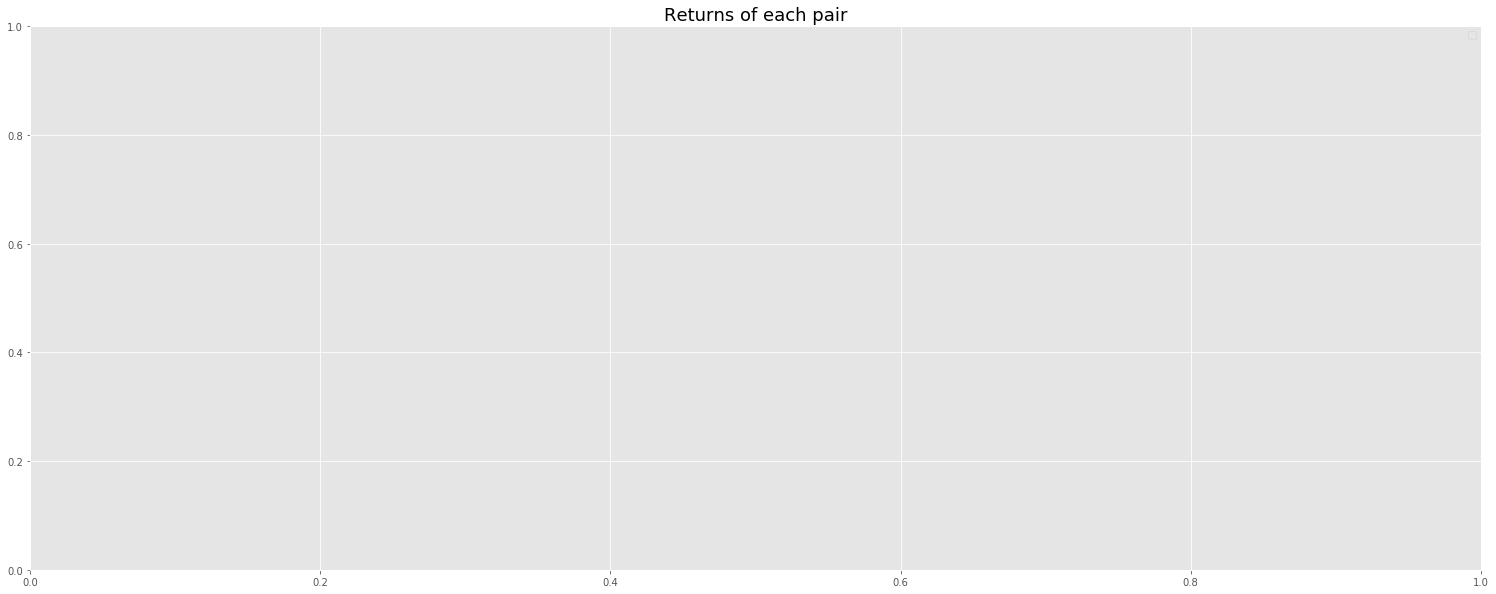

In [18]:
my_reduce = partial(pd.merge, on = 'date_of_trade', how = 'outer')
strategy_results = reduce(my_reduce, pairs_results.values())
strategy_results = strategy_results.sort_index()
strategy_results['final_res'] = strategy_results.filter(like = 'result', axis = 1).sum(axis = 1)
strategy_results['cum_res'] = strategy_results['final_res'].cumsum() + account_size

profits_keys = list(profits.keys())
profits_values = [profits[x] for x in profits_keys]
str_profits = list(flatten(profits_values))

losses_keys = list(losses.keys())
losses_values = [losses[x] for x in losses_keys]
str_losses = list(flatten(losses_values))

be_keys = list(be.keys())
be_values = [be[x] for x in be_keys]
str_be = list(flatten(be_values))

plt.figure(figsize = (26, 10))
#for pair in range(len(pairs_list)):
#    plt.plot(pairs_results[pair]['cum_res'], label = pairs_list[pair])
plt.legend()
plt.title('Returns of each pair', fontsize = 18)

In [19]:

#Strategy performance
print('***** STRATEGY PERFORMANCE *****')
print('--------------------------------')
print('CAGR:', CAGR(strategy_results, df[0]), '%')
print('Sharpe ratio:', sharpe_ratio(strategy_results))
print('Maximum drawdown', max_drawdown(strategy_results), '% \n')
print('Number of trades:', len(str_profits + str_losses + str_be))
print('Number of profits:', len(str_profits))
print('Number of losses:', len(str_losses))
print('Number of breakevens:', len(str_be), '\n')
print('Winning percentage', (round(len(str_profits) / (len(str_profits) + len(str_losses)) * 100, 2)), '%')
print('ROI:', round(strategy_results['cum_res'][-1]) - account_size)
print('--------------------------------')
#print('Average profitable trade:', round(sum(str_profits) / len(str_profits), 2))
#print('Average lossing trade:', round(sum(str_losses) / len(str_losses), 2))
#print('Max profitable trade:', round(max(str_profits), 2))
#print('Max lossing trade:', round(min(str_losses), 2))

***** STRATEGY PERFORMANCE *****
--------------------------------
CAGR: 21.3 %
Sharpe ratio: -0.04
Maximum drawdown 20.54 % 

Number of trades: 181
Number of profits: 76
Number of losses: 104
Number of breakevens: 1 

Winning percentage 42.22 %
ROI: 3551.0
--------------------------------


Text(0.5,1,'return of strategy')

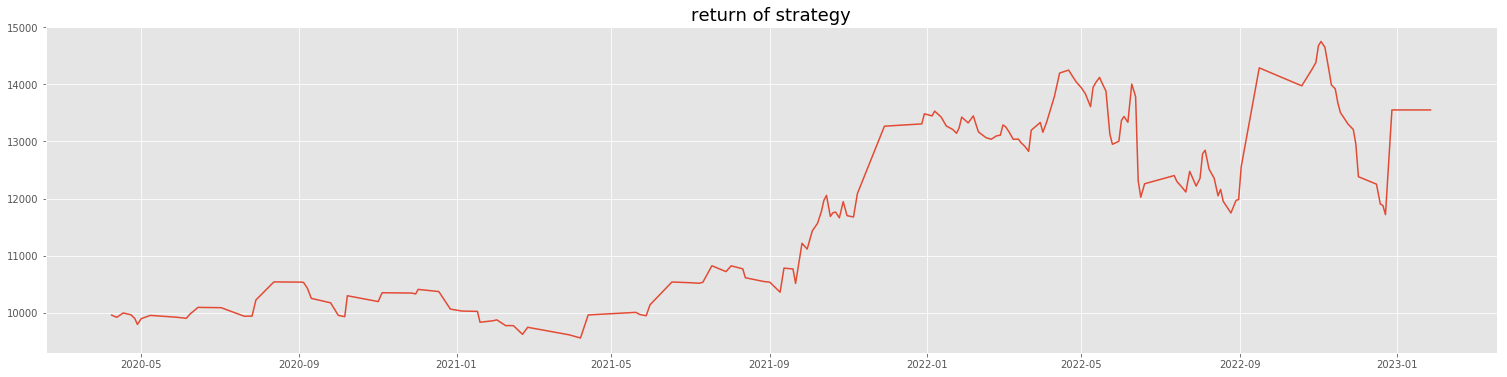

In [20]:

plt.figure(figsize = (26, 6))
plt.plot(strategy_results['cum_res'])
plt.title('return of strategy', fontsize = 18)


In [21]:

#performance for each pair
for pair in range(len(pairs_list)):
    print(pairs_list[pair], '- PERFORMANCE')
    print('--------------------------------')
    #print('Number of trades:', len(profits[pair] + losses[pair] + be[pair]))
    #print('Number of profits:', len(profits[pair]))
    #print('Number of losses:', len(losses[pair]))
    #print('Number of breakevens:', len(be[pair]), '\n')
    #print('Winning percentage', (round(len(profits[pair]) / (len(profits[pair]) + len(losses[pair])) * 100, 2)), '%')
    #print('ROI:', round(pairs_results[pair]['cum_res'][-1] - account_size, 2))
    #print('--------------------------------')
    #print('Average profitable trade:', round(sum(profits[pair]) / len(profits[pair]), 2))
    #print('Average lossing trade:', round(sum(losses[pair]) / len(losses[pair]), 2))
    #print('Max profitable trade:', round(max(profits[pair]), 2))
    #print('Max lossing trade:', round(min(losses[pair]), 2))
    #print('xxxxxxxxxxxxxxxxxxxxxxxxxxxxxx \n')

    trades_per_day = pairs_results[pair].groupby('day_of_trade').count()['result']
    day_return = pairs_results[pair].groupby('day_of_trade').sum()['result']
    day_return_positive = day_return > 0
    positive_results = pairs_results[pair]['result'] > 0

    print('Number of trades per day \n', trades_per_day)

    fig, axes = plt.subplots(4, 1, figsize = (26, 26))
    fig.tight_layout(pad = 4)

    axes[0].plot(pairs_results[pair]['cum_res'], color = 'dodgerblue')
    axes[0].set_title(pairs_list[pair], fontsize = 14)
    axes[0].set_xlabel('Days')
    axes[0].set_ylabel('Return')

    axes[1].bar(day_return.keys(), height = day_return, color = day_return_positive.map({True: 'limegreen', False: 'coral'}))
    axes[1].set_title('Returns per day', fontsize = 14)
    axes[1].set_xlabel('Days')
    axes[1].set_ylabel('Return')

    axes[2].hist(pairs_results[pair]['result'], bins = 500, color = 'purple')
    axes[2].set_title('Distribution of results', fontsize = 14)
    axes[2].set_xlabel('Size of returns')
    axes[2].set_ylabel('Number of returns')

    axes[3].plot(df[pair]['Close'], color = 'black', alpha = 0.5)
    axes[3].scatter(pairs_results[pair].index, pairs_results[pair]['entry_price'], s = 70, color = positive_results.map({True: 'green', False: 'red'}))
    axes[3].set_title('Entries', fontsize = 14)
    axes[3].set_xlabel('Date')
    axes[3].set_ylabel('price')

    plt.show()


naturalgas_15Min - PERFORMANCE
--------------------------------


KeyError: 0